In [15]:
%load_ext autoreload
%autoreload 2
import sys
if "../../../" not in sys.path:
    sys.path.append("../../../")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import json
import os

from volterra_hawkes.iVi.iVi_hawkes import IVIHawkesProcess
from volterra_hawkes.kernel.kernels import *
from volterra_hawkes.point_processes.hawkes import U_from_jumps
from notebooks.dev.visualisation import plot_trajectories, poisson_jumps_test, plot_cf_convergence
from notebooks.dev.experiments import Experiment, get_N_U_sample, get_arrivals_sample, test_marginal_laws, test_laplace_transform

plt.style.use('seaborn-v0_8-deep')
plt.style.use('default')  # 'default' or any other light theme like 'seaborn-white'

color_cycle = ["#B56246", "#579F40", "#9A46B5", "#4699B5", "#B54662", "#D4A017", "#5b6c64", "#71074E", "#0033A0"]
plt.rcParams["figure.figsize"]        = ((1 + np.sqrt(5)) / 2 * 5, 5)
plt.rcParams["figure.autolayout"]     = True
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams["axes.grid"]             = True
plt.rcParams['axes.prop_cycle']       = matplotlib.cycler(color=color_cycle)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
SEED = 42
path_article = "../images/inar/"

# I. Gamma kernel

In [7]:
lam = 3
alpha = 2
experiment_gamma = Experiment(
    T=1,
    n_steps=1000,
    kernel=GammaKernel(lam=lam, alpha=alpha, c=0.9 * lam ** alpha),
    mu=5,
)

path_experiment = path_article + "gamma_kernel" + "/"
try:
    os.mkdir(path_experiment)
except FileExistsError as _:
    pass

### Sample paths

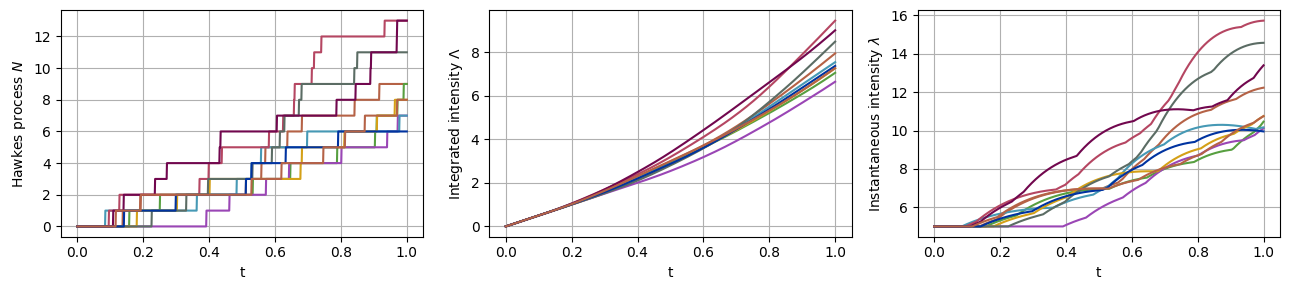

In [8]:
plot_trajectories(experiment_gamma, path=path_experiment + "gamma_sample_traj.pdf")

### Convergence of the Laplace transform

In [9]:
methods_non_ivi = ["Population", "Ogata"]
methods_ivi = ["iVi"] # "Res iVi"
n_paths_time_meas = 10**5
batch_size_cf = 10**5
n_batch_cf = 10
n_steps_arr_cf = [20, 35, 50, 65, 80, 100, 200, 350, 500, 750, 1000]
is_log_time = False

experiment_results = dict()
experiment_results["is_log_time"] = is_log_time
experiment_results["methods_ivi"] = methods_ivi
experiment_results["methods_non_ivi"] = methods_non_ivi
experiment_results["n_paths_time_meas"] = n_paths_time_meas
experiment_results["n_steps_arr_cf"] = n_steps_arr_cf
experiment_results["n_batch_cf"] = n_batch_cf
experiment_results["batch_size_cf"] = batch_size_cf

In [10]:
print("Pre-computing non-iVi samples...")
experiment_results["n_paths_non_ivi"] = 10_000
samples_non_ivi = {}
for method in methods_non_ivi:
    time_non_ivi = time.time()
    samples_non_ivi[method] = get_N_U_sample(experiment=experiment_gamma, method=method,
                                             n_paths=experiment_results["n_paths_non_ivi"])
    time_non_ivi = time.time() - time_non_ivi
    experiment_results["time_" + method] = time_non_ivi * (experiment_results["n_paths_time_meas"] /
                                                           experiment_results["n_paths_non_ivi"])

Pre-computing non-iVi samples...


Computing iVi samples...
Mean: 7.372316044381228
iVi 20
iVi 35
iVi 50
iVi 65
iVi 80
iVi 100
iVi 200
iVi 350
iVi 500
iVi 750
iVi 1000


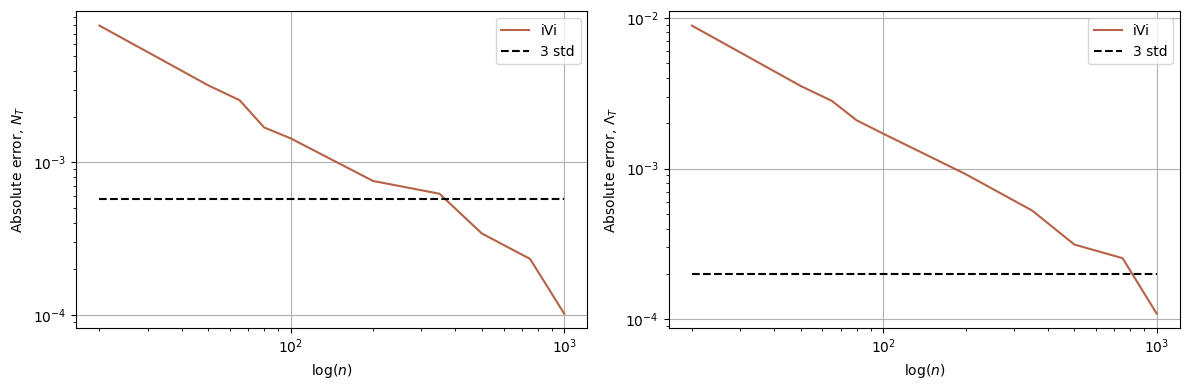

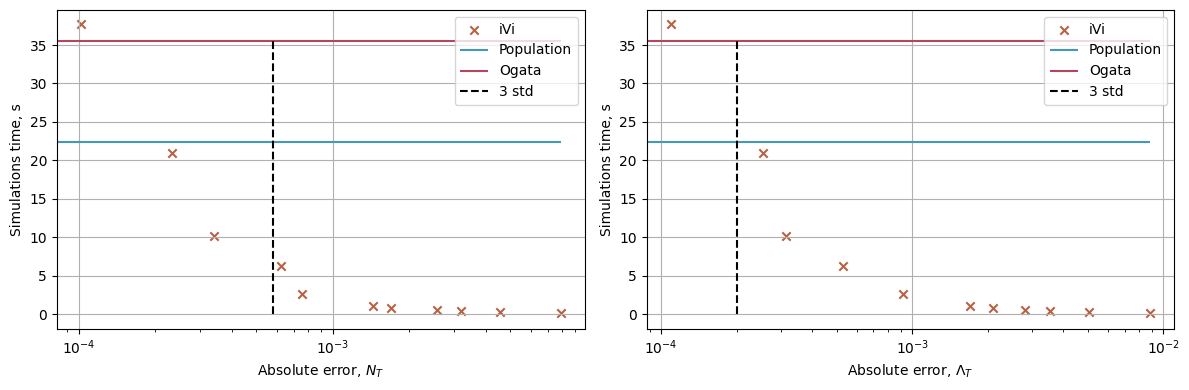

In [11]:
test_laplace_transform(experiment_gamma, path_experiment, experiment_results, samples_non_ivi)

with open(path_experiment + 'results_gamma.json', 'w') as f:
        json.dump(experiment_results, f)

### Plotting marginal laws

Computing iVi samples...
n_steps = 100
p-value Population-Ogata: 0.11890214798175557
p-value Population-iVi: 0.21692483428445863
p-value Population-Ogata: 0.031162582913927636
p-value Population-iVi: 0.22343759648123543


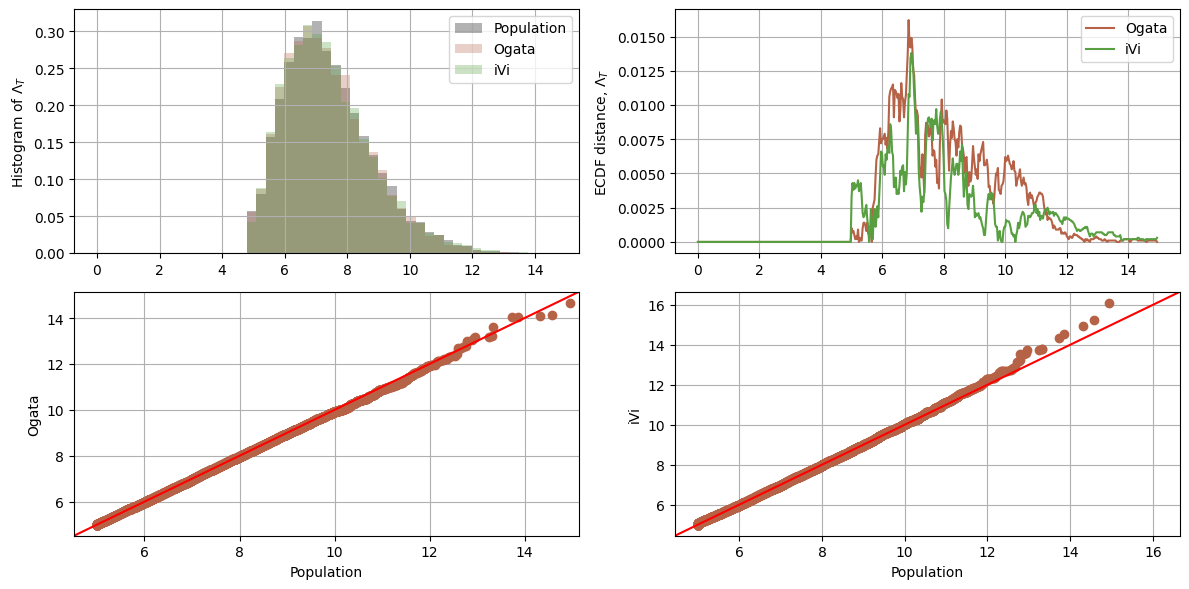

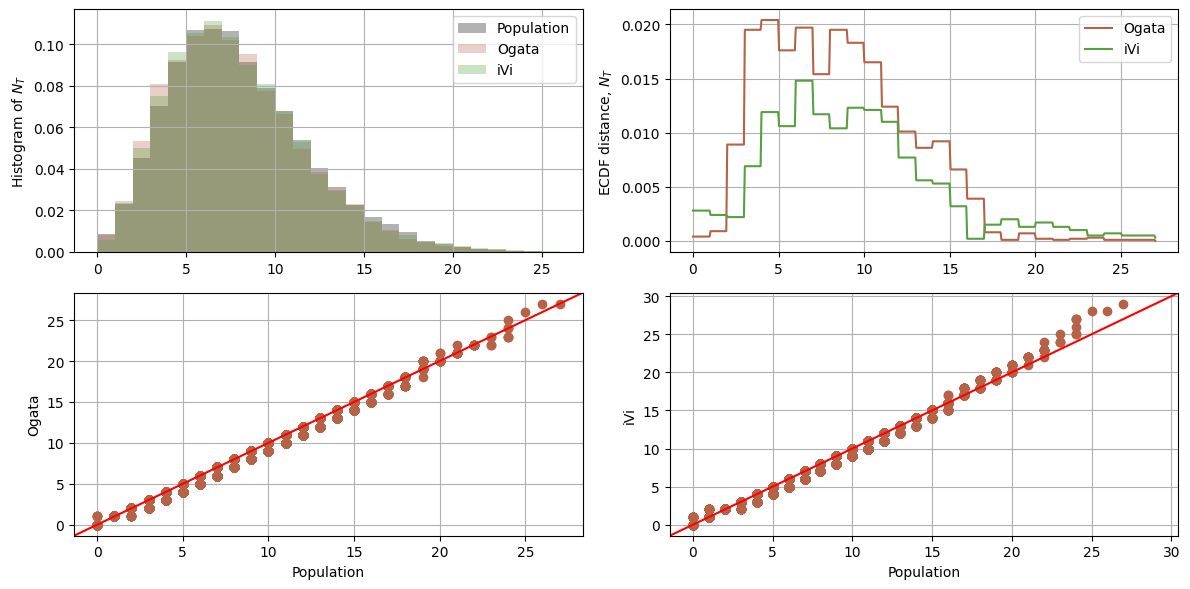

In [12]:
test_marginal_laws(experiment_gamma, path_experiment, experiment_results, samples_non_ivi)

with open(path_experiment + 'results_gamma.json', 'w') as f:
        json.dump(experiment_results, f)

### Simulation of arrival times

Population
Kolmogorov-Smirnov test p-value:  0.6898771332858613
Ogata
Kolmogorov-Smirnov test p-value:  0.25663392986954725
iVi
Kolmogorov-Smirnov test p-value:  0.4324032061886227


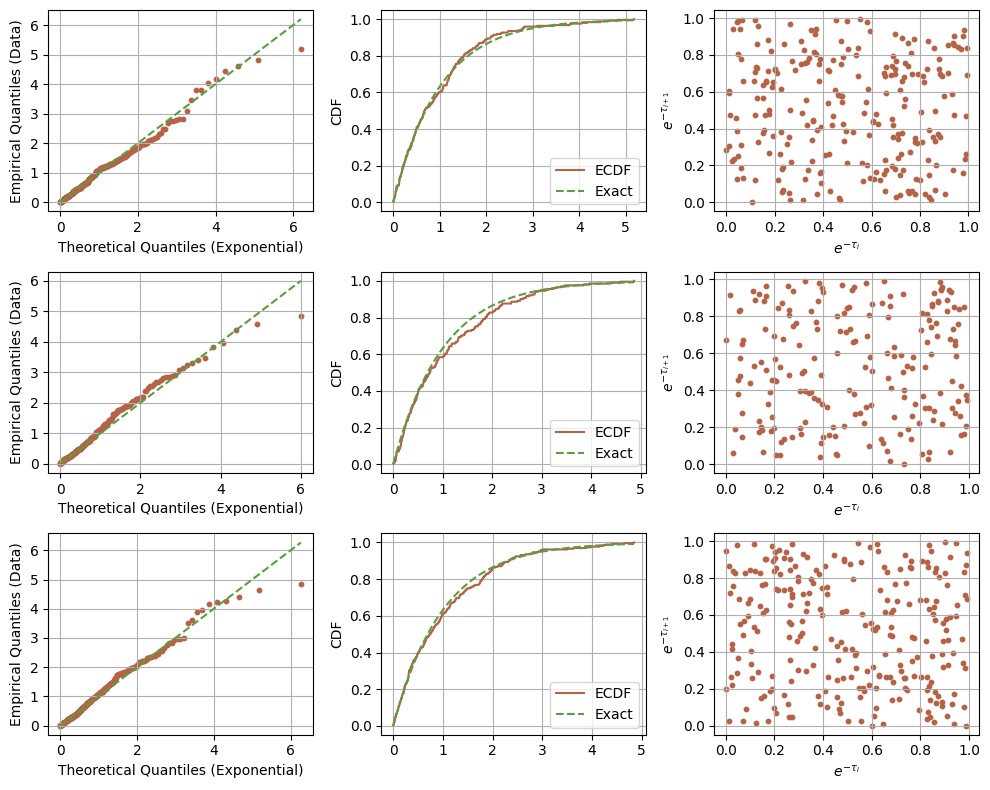

In [13]:
experiment_gamma_T10 = Experiment(
    T=10,
    n_steps=1000,
    kernel=GammaKernel(lam=lam, alpha=alpha, c=0.9 * lam ** alpha),
    mu=5,
)

methods = ["Population", "Ogata", "iVi"]

fig, axes = plt.subplots(3, 3, figsize=(10, 8))

for method, ax in zip(methods, axes):
    rng = np.random.default_rng(seed=SEED)
    samples_arrivals = get_arrivals_sample(experiment=experiment_gamma_T10, method=method, n_paths=1, rng=rng)
    print(method)
    ivi_hawkes = IVIHawkesProcess(kernel=experiment_gamma_T10.kernel, g0_bar=experiment_gamma_T10.g0_bar, rng=rng,
                                  g0=experiment_gamma_T10.g0, resolvent_flag=False)
    poisson_jumps_test(U_from_jumps(samples_arrivals[0], samples_arrivals[0],
                                    kernel=experiment_gamma_T10.kernel, g0_bar=experiment_gamma_T10.g0_bar),
                       ax=ax, fig=fig,
                       path=path_experiment + "/arrivals_gamma.pdf")

# II. Fractional kernel

In [16]:
scale = 30
H = 0.1
c = 0.1
mu = 5

experiment_fractional = Experiment(
    T=1,
    n_steps = 1000,
    kernel = FractionalKernel(H=H, c=c * scale**(H + 0.5)),
    mu=mu * scale
)

path_experiment = path_article + "fractional_kernel" + "/"
try:
    os.mkdir(path_experiment)
except FileExistsError as _:
    pass

### Convergence of the Laplace transform

In [17]:
methods_non_ivi = ["Population", "Ogata"]
methods_ivi = ["iVi", "Res iVi"]
n_paths_time_meas = 10**5
batch_size_cf = 10**5
n_batch_cf = 10
n_steps_arr_cf = [20, 35, 50, 65, 80, 100, 200, 350, 500, 750, 1000]
is_log_time = True

experiment_results = dict()
experiment_results["is_log_time"] = is_log_time
experiment_results["methods_ivi"] = methods_ivi
experiment_results["methods_non_ivi"] = methods_non_ivi
experiment_results["n_paths_time_meas"] = n_paths_time_meas
experiment_results["n_steps_arr_cf"] = n_steps_arr_cf
experiment_results["n_batch_cf"] = n_batch_cf
experiment_results["batch_size_cf"] = batch_size_cf

In [18]:
print("Pre-computing non-iVi samples...")
experiment_results["n_paths_non_ivi"] = 10_000
samples_non_ivi = {}
for method in methods_non_ivi:
    time_non_ivi = time.time()
    samples_non_ivi[method] = get_N_U_sample(experiment=experiment_fractional, method=method,
                                             n_paths=experiment_results["n_paths_non_ivi"])
    time_non_ivi = time.time() - time_non_ivi
    experiment_results["time_" + method] = time_non_ivi * (experiment_results["n_paths_time_meas"] /
                                                           experiment_results["n_paths_non_ivi"])

Pre-computing non-iVi samples...


In [ ]:
test_laplace_transform(experiment_fractional, path_experiment, experiment_results, samples_non_ivi)

with open(path_experiment + 'results_fractional.json', 'w') as f:
        json.dump(experiment_results, f)

Computing iVi samples...
Mean: 288.1422726513042
iVi 20
iVi 35
iVi 50
iVi 65


In [14]:
experiment_results['time_Population'] / experiment_results['time_Res iVi_65']

1656.7665783803118

# III. Exponential kernel

In [14]:
scaling = 2
c = 4
lam = 5
mu = 10

experiment_exponential = Experiment(
    T=1,
    n_steps = 1000,
    kernel = ExponentialKernel(c=c * scaling, lam=lam * scaling),
    mu=mu * scaling
)

path_experiment = path_article + "exponential_kernel" + "/"
try:
    os.mkdir(path_experiment)
except FileExistsError as _:
    pass

### Convergence of the Laplace transform

In [16]:
methods_non_ivi = ["ExpExact", "Ogata"]
methods_ivi = ["iVi", "Res iVi"]
n_paths_time_meas = 10**5
batch_size_cf = 10**5
n_batch_cf = 10
n_steps_arr_cf = [20, 35, 50, 65, 80, 100, 200, 350, 500, 750, 1000, 2000]
is_log_time = False

experiment_results = dict()
experiment_results["is_log_time"] = is_log_time
experiment_results["methods_ivi"] = methods_ivi
experiment_results["methods_non_ivi"] = methods_non_ivi
experiment_results["n_paths_time_meas"] = n_paths_time_meas
experiment_results["n_steps_arr_cf"] = n_steps_arr_cf
experiment_results["n_batch_cf"] = n_batch_cf
experiment_results["batch_size_cf"] = batch_size_cf

In [17]:
print("Pre-computing non-iVi samples...")
experiment_results["n_paths_non_ivi"] = 10_000
samples_non_ivi = {}
for method in methods_non_ivi:
    time_non_ivi = time.time()
    samples_non_ivi[method] = get_N_U_sample(experiment=experiment_exponential, method=method,
                                             n_paths=experiment_results["n_paths_non_ivi"])
    time_non_ivi = time.time() - time_non_ivi
    experiment_results["time_" + method] = time_non_ivi * (experiment_results["n_paths_time_meas"] /
                                                           experiment_results["n_paths_non_ivi"])

Pre-computing non-iVi samples...


Computing iVi samples...
Mean: 65.33336952141568
iVi 20
iVi 35
iVi 50
iVi 65
iVi 80
iVi 100
iVi 200
iVi 350
iVi 500
iVi 750
iVi 1000
iVi 2000
Res iVi 20
Res iVi 35
Res iVi 50
Res iVi 65
Res iVi 80
Res iVi 100
Res iVi 200
Res iVi 350
Res iVi 500
Res iVi 750
Res iVi 1000
Res iVi 2000


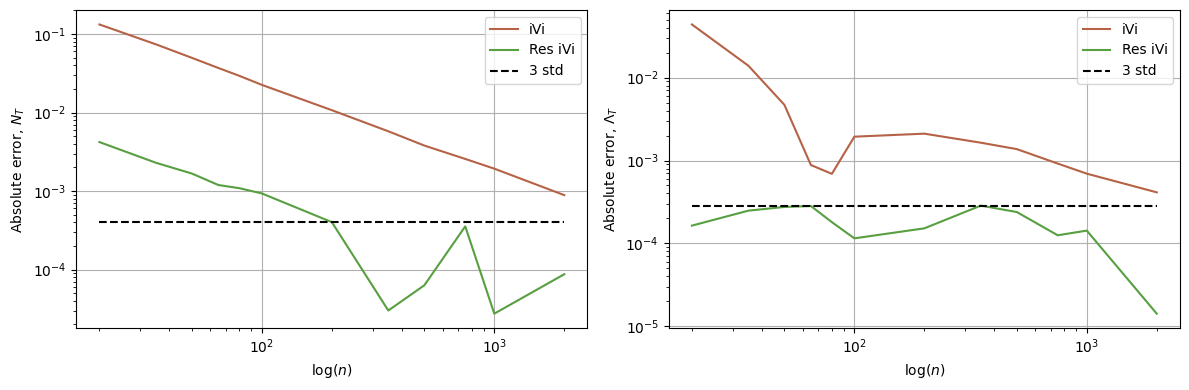

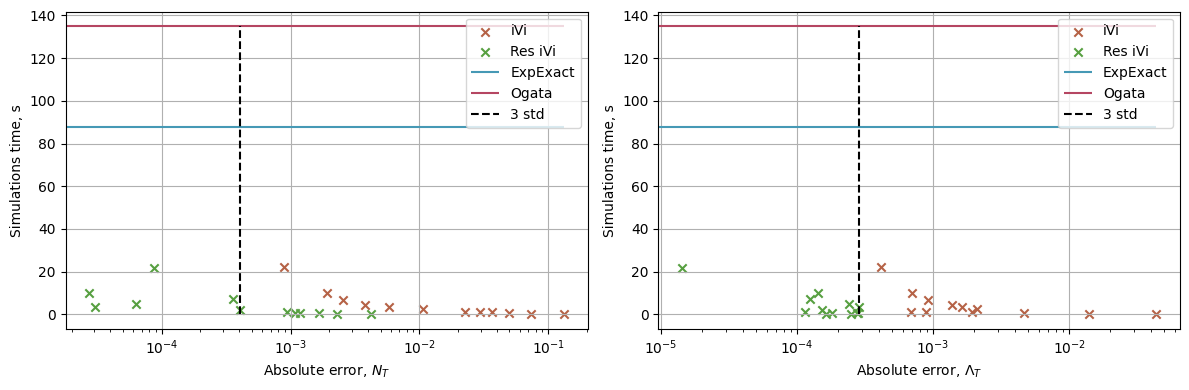

In [18]:
test_laplace_transform(experiment_exponential, path_experiment, experiment_results, samples_non_ivi)

with open(path_experiment + 'results_exponential.json', 'w') as f:
        json.dump(experiment_results, f)

In [19]:
experiment_results['time_ExpExact'] / experiment_results['time_Res iVi_200']

48.566019448143

Explicit vs implicit schemes

In [13]:
with open('../images/inar/fractional_kernel/results_fractional.json') as f:
    experiment_results_explicit = json.load(f)

with open('../images/article/fractional_kernel/results_fractional.json') as f:
    experiment_results_ivi = json.load(f)

experiment_results_merged = experiment_results_ivi.copy()

experiment_results_merged["methods_ivi"] = ["Explicit", "iVi"]

del experiment_results_merged['errors_ivi']["U"]["Res iVi"]
del experiment_results_merged['errors_ivi']["N"]["Res iVi"]

experiment_results_merged['errors_ivi']["U"]["Explicit"] = experiment_results_explicit['errors_ivi']["U"]["iVi"]
experiment_results_merged['errors_ivi']["N"]["Explicit"] = experiment_results_explicit['errors_ivi']["N"]["iVi"]

for i in experiment_results_merged["n_steps_arr_cf"]:
    experiment_results_merged["time_Explicit_" + str(i)] = experiment_results_explicit["time_iVi_" + str(i)]

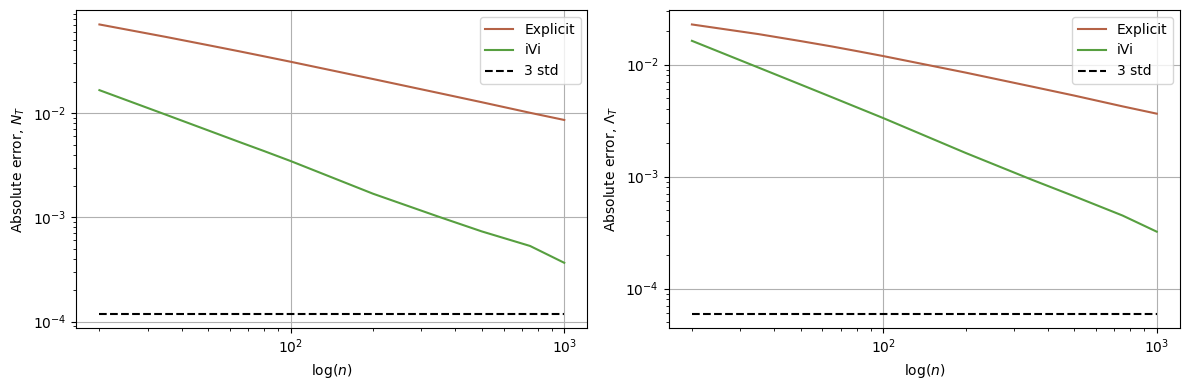

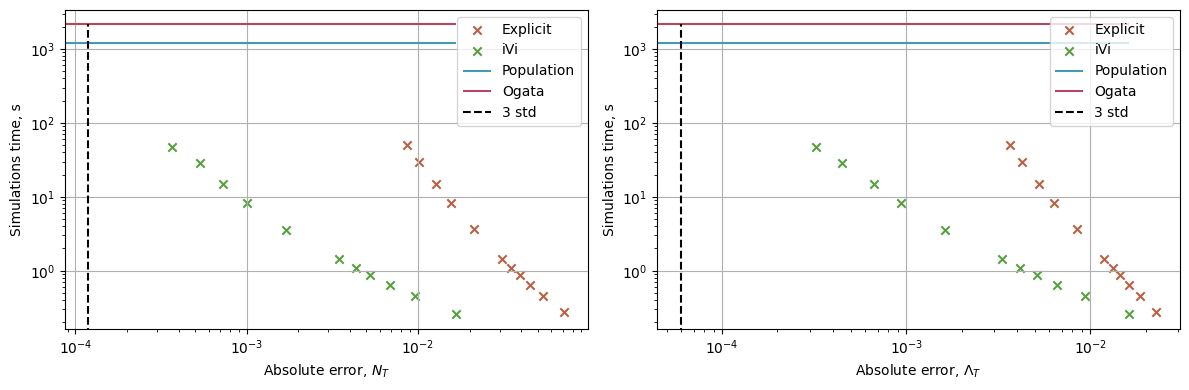

In [14]:
plot_cf_convergence(results=experiment_results_merged, path_experiment='../images/explicit/', is_log_time=True)